In [1]:
# Download Dataset

!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json -O /tmp/sarcasm.json

--2022-01-27 14:33:17--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.45.112, 172.253.63.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.45.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.02s   

2022-01-27 14:33:17 (306 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



## Read Dataset

In [2]:
import pandas as pd


# Read dataset
df = pd.read_json("/tmp/sarcasm.json")

In [3]:
print(df.columns)
# Check class balance
print(df['is_sarcastic'].value_counts())

Index(['article_link', 'headline', 'is_sarcastic'], dtype='object')
0    14985
1    11724
Name: is_sarcastic, dtype: int64


## Create input lists

In [4]:
# Convert columns to lists
sentences = df['headline'].to_list()
labels = df['is_sarcastic'].to_list()

print(sentences[0])
print(labels[0])
print('Number of sentences:', len(sentences))

former versace store clerk sues over secret 'black code' for minority shoppers
0
Number of sentences: 26709


## Preprocessing

In [5]:
num_words = 25000
embedding_dim = 10
max_len = 30

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords


nltk.download('stopwords')
sw = stopwords.words('english')

for i in range(len(sentences)):
    words = sentences[i].split()
    # List Comprehension
    words2 = [w for w in words if w not in sw]
    sentences[i] = ' '.join(words2)

# Split data into train/valid
TRAIN_SIZE = 20000
train_sentences = sentences[0:TRAIN_SIZE]
valid_sentences = sentences[TRAIN_SIZE:]

train_labels = labels[0:TRAIN_SIZE]
valid_labels = labels[TRAIN_SIZE:]

# Tokenization
tokenizer = Tokenizer(oov_token='<oov>', num_words=num_words)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index
print(word_index)
print('Number of words =', len(word_index))

# Sequencing
train_sequences = tokenizer.texts_to_sequences(train_sentences)
print(train_sequences)

# Padding
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_len)
print(train_padded.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'<oov>': 1, 'new': 2, 'trump': 3, 'man': 4, 'one': 5, 'year': 6, 'report': 7, 'area': 8, 'u': 9, 'donald': 10, 'says': 11, 'day': 12, 's': 13, 'first': 14, 'woman': 15, 'time': 16, 'like': 17, 'get': 18, 'old': 19, "trump's": 20, 'obama': 21, 'life': 22, 'people': 23, 'women': 24, 'house': 25, "'": 26, 'still': 27, 'white': 28, 'back': 29, 'make': 30, 'clinton': 31, '5': 32, 'could': 33, 'world': 34, 'americans': 35, 'way': 36, 'study': 37, 'family': 38, 'gop': 39, 'black': 40, 'best': 41, 'bill': 42, 'school': 43, 'police': 44, 'years': 45, 'president': 46, 'know': 47, '3': 48, 'watch': 49, 'would': 50, 'last': 51, 'really': 52, '10': 53, 'video': 54, 'show': 55, "can't": 56, 'going': 57, 'death': 58, 'hillary': 59, 'finds': 60, 'american': 61, 'things': 62, 'good': 63, 'state': 64, 'home': 65, 'may': 66, 'love': 67, 'health': 68, 'say': 69, 'need': 70, 'nation': 71,

## Create and Train Model

### Create Model

In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

In [8]:
model1 = Sequential([
                    layers.Dense(100, activation='relu', input_shape=[train_padded.shape[1],]),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1, activation='sigmoid')
])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3100      
                                                                 
 dense_1 (Dense)             (None, 32)                3232      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,365
Trainable params: 6,365
Non-trainable params: 0
_________________________________________________________________


In [9]:
model2 = Sequential([
                     layers.Embedding(input_dim=num_words,
                                      output_dim=embedding_dim,
                                      input_length=max_len),
                     layers.GlobalAveragePooling1D(),
                     layers.Dense(32, activation='relu'),
                     layers.Dense(8, activation='relu'),
                     layers.Dense(1, activation='sigmoid')                  
])

model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 10)            100000    
                                                                 
 global_average_pooling1d (G  (None, 10)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_3 (Dense)             (None, 32)                352       
                                                                 
 dense_4 (Dense)             (None, 8)                 264       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 100,625
Trainable params: 100,625
Non-trainable params: 0
________________________________________________

In [10]:
model3 = Sequential([
                     layers.Embedding(input_dim=num_words,
                                      output_dim=embedding_dim,
                                      input_length=max_len),
                     layers.Conv1D(8, 5, activation='relu', padding='same'),
                     layers.GlobalAveragePooling1D(),
                     layers.Dense(32, activation='relu'),
                     layers.Dense(8, activation='relu'),
                     layers.Dense(1, activation='sigmoid')                  
])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 10)            100000    
                                                                 
 conv1d (Conv1D)             (None, 30, 8)             408       
                                                                 
 global_average_pooling1d_1   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 32)                288       
                                                                 
 dense_7 (Dense)             (None, 8)                 264       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                      

In [11]:
model4 = Sequential([
                     layers.Embedding(input_dim=num_words,
                                      output_dim=embedding_dim,
                                      input_length=max_len),
                     layers.LSTM(16),
                     layers.Dense(32, activation='relu'),
                     layers.Dense(8, activation='relu'),
                     layers.Dense(1, activation='sigmoid')                  
])

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 10)            100000    
                                                                 
 lstm (LSTM)                 (None, 16)                1728      
                                                                 
 dense_9 (Dense)             (None, 32)                544       
                                                                 
 dense_10 (Dense)            (None, 8)                 264       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 102,545
Trainable params: 102,545
Non-trainable params: 0
_________________________________________________________________


In [23]:
model5 = Sequential([
                     layers.Embedding(input_dim=num_words,
                                      output_dim=embedding_dim,
                                      input_length=max_len),
                     layers.Bidirectional(layers.GRU(16)),
                     layers.Dense(32, activation='relu'),
                     layers.Dense(8, activation='relu'),
                     layers.Dense(1, activation='sigmoid')                  
])

model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 30, 10)            100000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               2688      
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 32)                1056      
                                                                 
 dense_16 (Dense)            (None, 8)                 264       
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 104,017
Trainable params: 104,017
Non-trainable params: 0
________________________________________________

In [24]:
model = model5

In [25]:
import numpy as np
from tensorflow.keras import losses


valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
valid_padded = pad_sequences(valid_sequences, padding='post', maxlen=30)

train_padded = np.array(train_padded)
valid_padded = np.array(valid_padded)
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)


model.compile(optimizer='adam', loss=losses.binary_crossentropy)

history = model.fit(x=train_padded, y=train_labels,
                    epochs=30,
                    validation_data=(valid_padded, valid_labels))

Epoch 1/30
625/625 [==============================] - 7s 8ms/step - loss: 0.5016 - val_loss: 0.4241
Epoch 2/30
625/625 [==============================] - 5s 7ms/step - loss: 0.2961 - val_loss: 0.4209
Epoch 3/30
625/625 [==============================] - 5s 7ms/step - loss: 0.2039 - val_loss: 0.4843
Epoch 4/30
625/625 [==============================] - 5s 7ms/step - loss: 0.1323 - val_loss: 0.5521
Epoch 5/30
625/625 [==============================] - 5s 7ms/step - loss: 0.0879 - val_loss: 0.6998
Epoch 6/30
625/625 [==============================] - 5s 7ms/step - loss: 0.0603 - val_loss: 0.8086
Epoch 7/30
625/625 [==============================] - 5s 7ms/step - loss: 0.0408 - val_loss: 0.9748
Epoch 8/30
625/625 [==============================] - 5s 7ms/step - loss: 0.0297 - val_loss: 1.0678
Epoch 9/30
625/625 [==============================] - 4s 7ms/step - loss: 0.0222 - val_loss: 1.2777
Epoch 10/30
625/625 [==============================] - 4s 7ms/step - loss: 0.0201 - val_loss: 1.2199

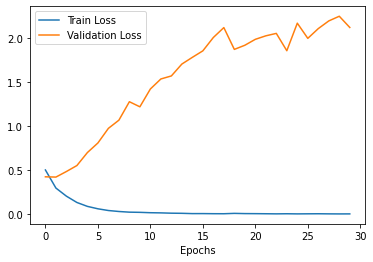

In [26]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1)
ax.plot(history.history['loss'], label='Train Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epochs')
plt.legend()
plt.show()